In [1]:
import pandas as pd
import numpy as np
import time
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 

from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR


from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve 
from sklearn.utils import shuffle
from sklearn.ensemble import VotingRegressor


In [2]:
def metrica(model, X_train, Y_train, X_test, Y_test, y_mean, y_std, DataNorm = True):
    print('Primero vemos las metricas')
    abr_score = model.score(X_train,Y_train) #Se evalua que tan bien entredo 
    abr_score1 = model.score(X_test,Y_test) #Que tan bueno es en el conjunto de test
    y_predicted = model.predict(X_test) #Hacemos la inferencia con el conjunto test
    if DataNorm == True:
        yp = y_predicted*y_std + y_mean
        yt = Y_test*y_std + y_mean
        print('Model| R2 sq on train set: %.4f'% abr_score)  #Mostramos las metricas que se obtuvieron.
        print('Model| R2 sq on test set: %.4f'% abr_score1)
        print('Model| MSE on test set: %.4f'% mean_squared_error(yt, yp))
        print('Model| MAE on test set: %.4f'% mean_absolute_error(yt, yp))   
        print('Ahora lo que vemos son la diferencia entre el valor real y el predicho')
        dif = yp-yt

        fig = plt.figure(figsize=(20, 6))

        plt.subplot(1, 3, 1)
        plt.hist(x=dif, bins=25, color='#F2AB6D')
        plt.title('Histograma de Diferencia entre el valor real y predicho')
        plt.xlabel('Diferencia en eV')
        plt.ylabel('Frecuencia')

        for i in range(len(yt)):
            if yt[i] == 0.0:
                yt[i] = 0.0001
        plt.subplot(1, 3, 2)
        dif1 = (abs(y_predicted - Y_test) / Y_test)*100
        plt.hist(x=dif1, bins=200, color='#F2AB6D')
        plt.title('Histograma del procentaje de error (de los datos normalizados)')
        plt.xlabel('Error porcentual')
        plt.ylabel('Frecuencia Número de observaciones')
        plt.xlim(-100,100)
        plt.subplot(1,3,3)
        plt.plot(yt,yt,'o')
        plt.plot(yt,yp,'o')
        plt.xlabel('eV')
        plt.ylabel('eV')
        plt.grid()
        plt.show
    else:
        yp = y_predicted#*y_std + y_mean
        yt = Y_test#*y_std + y_mean
        print('Model| R2 sq on train set: %.4f'% abr_score)  #Mostramos las metricas que se obtuvieron.
        print('Model| R2 sq on test set: %.4f'% abr_score1)
        print('Model| MSE on test set: %.4f'% mean_squared_error(yt, yp))
        print('Model| MAE on test set: %.4f'% mean_absolute_error(yt, yp))   
        print('Ahora lo que vemos son la diferencia entre el valor real y el predicho')
        dif = yp-yt

        fig = plt.figure(figsize=(20, 6))

        plt.subplot(1, 3, 1)
        plt.hist(x=dif, bins=25, color='#F2AB6D')
        plt.title('Histograma de Diferencia entre el valor real y predicho')
        plt.xlabel('Diferencia en eV')
        plt.ylabel('Frecuencia')

        for i in range(len(yt)):
            if yt[i] == 0.0:
                yt[i] = 0.0001
        plt.subplot(1, 3, 2)
        dif1 = (abs(y_predicted - Y_test) / Y_test)*100
        plt.hist(x=dif1, bins=200, color='#F2AB6D')
        plt.title('Histograma del procentaje de error (de los datos normalizados)')
        plt.xlabel('Error porcentual')
        plt.ylabel('Frecuencia Número de observaciones')
        plt.xlim(-100,100)
        plt.subplot(1,3,3)
        plt.plot(yt,yt,'o')
        plt.plot(yt,yp,'o')
        plt.xlabel('eV')
        plt.ylabel('eV')
        plt.grid()
        plt.show

In [3]:
def FeatureIm(model,x):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(6, 25))
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(x.columns)[sorted_idx])
    plt.title("Feature Importance (MDI)")
    plt.show()

In [4]:
def Dataset(NsitesTrue = True, Nsites = 10, Target = 'Band_gap', Norm = True): #NsitesTrue debe ser True cuando se utiliza solo un tipo de estructura, Nsites debe ser un valor int 5, 10, target debe ser str y es igual a la variable objetivo,
    #Norm cuando es True se normaliza, si es False no se normaliza
    df = pd.read_csv('DatasetPerovskitasJuan.csv') 
    df = df.drop('Unnamed: 0', axis = 1)
    df = df.drop('ID', axis = 1)
    df = df.drop('full_formula', axis = 1)
    if NsitesTrue == True:
        df = df[df['Nsites'] == Nsites]
        #df = shuffle(df, random_state=2)
        x = df
        x = x.drop('Energy', axis = 1)
        x = x.drop('Energy_per_atom', axis = 1)
        x = x.drop('Formation_energy_per_atom', axis = 1)
        x = x.drop('E_above_hull', axis = 1)
        x = x.drop("Band_gap",axis = 1)
        y = np.asarray(df[Target])
        y_mean = y.mean()
        y_std = y.std()
        if Norm == True:
            x = (x-x.mean())/x.std()
            y = (y-y_mean)/y_std
            x = x.fillna(0)
        x = x.fillna(0)
    else:
        #df = shuffle(df, random_state=2)
        x = df
        x = x.drop('Energy', axis = 1)
        x = x.drop('Energy_per_atom', axis = 1)
        x = x.drop('Formation_energy_per_atom', axis = 1)
        x = x.drop('E_above_hull', axis = 1)
        x = x.drop("Band_gap",axis = 1)
        y = np.asarray(df[Target])
        y_mean = y.mean()
        y_std = y.std()
        if Norm == True:
            x = (x-x.mean())/x.std()
            y = (y-y_mean)/y_std
            x = x.fillna(0)
        x = x.fillna(0)
    X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.1, random_state=9)
    return X_train, X_test, y_train, y_test, float(y_mean), float(y_std)

In [5]:
df = pd.read_csv('DatasetPerovskitasJuan.csv') 
df.drop_duplicates(subset = ['full_formula'],inplace=True)
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop('ID', axis = 1)
df 

full_formula  Nsites  Nelements   A Z  A Period_Number  A Group_Number  \
0        Ac1Al1O3     5.0        3.0  90.0              7.0             5.0   
1         Ac1B1O3     5.0        3.0  90.0              7.0             5.0   
2        Ac1Cr1O3     5.0        3.0  90.0              7.0             5.0   
3        Ac1Cu1O3     5.0        3.0  90.0              7.0             5.0   
4        Ac1Fe1O3     5.0        3.0  90.0              7.0             5.0   
...           ...     ...        ...   ...              ...             ...   
1818  Sr2Zn1Mo1O6    10.0        4.0  39.0              5.0             3.0   
1819  Sr2Zn1Re1O6    10.0        4.0  39.0              5.0             3.0   
1820   Sr2Zn1W1O6    10.0        4.0  39.0              5.0             3.0   
1821  Sr2Zr1Co1O6    10.0        4.0  39.0              5.0             3.0   
1822  Sr2Zr1Ti1O6    10.0        4.0  39.0              5.0             3.0   

      A Electronegativity  A Covalent_radius  A Valence_Electrons  \
0                    1.30              206.0                  2.0   
1                    1.30              206.0                  2.0   
2                    1.30              206.0                  2.0   
3                    1.30              206.0                  2.0   
4                    1.30              206.0                  2.0   
...                   ...                ...                  ...   
1818                 1.22              190.0                  2.0   
1819                 1.22              190.0                  2.0   
1820                 1.22              190.0                  2.0   
1821                 1.22              190.0                  2.0   
1822                 1.22              190.0                  2.0   

      A Ionization_Energy  ...  X6 Volume  X6 Density  X6 Atomic_Weight  \
0                    6.08  ...       0.00       0.000            0.0000   
1                    6.08  ...       0.00       0.000            0.0000   
2                    6.08  ...       0.00       0.000            0.0000   
3                    6.08  ...       0.00       0.000            0.0000   
4                    6.08  ...       0.00       0.000            0.0000   
...                   ...  ...        ...         ...               ...   
1818                 6.22  ...   18601.17       1.696           18.9984   
1819                 6.22  ...   18601.17       1.696           18.9984   
1820                 6.22  ...   18601.17       1.696           18.9984   
1821                 6.22  ...   18601.17       1.696           18.9984   
1822                 6.22  ...   18601.17       1.696           18.9984   

       volume-py  density-py     Energy  Energy_per_atom  \
0      58.671145    8.546776 -39.099719        -7.819944   
1      51.548126    9.206879 -35.960398        -7.192080   
2      63.488393    8.552537 -40.252962        -8.050592   
3      61.365464    9.160949 -33.117727        -6.623545   
4      64.691419    8.492286 -36.975717        -7.395143   
...          ...         ...        ...              ...   
1818  130.244222    5.515216 -63.329499        -6.332950   
1819  128.938009    6.733599 -68.223485        -6.822349   
1820  131.440876    6.575476 -65.368619        -6.536862   
1821  125.355291    5.582058 -69.945483        -6.994548   
1822  136.397277    4.995442 -81.010761        -8.101076   

      Formation_energy_per_atom  E_above_hull  Band_gap  
0                     -3.699194      0.000000    4.1024  
1                     -2.484567      0.792473    0.8127  
2                     -3.150949      0.000000    2.0832  
3                     -2.432070      0.000000    0.0000  
4                     -2.876250      0.000000    1.1671  
...                         ...           ...       ...  
1818                  -2.590245      0.025261    2.3708  
1819                  -2.566654      0.043362    0.0000  
1820                  -2.664908      0.018638    3.4564  
1821                  -2.

In [6]:
df['Band_gap'].describe()

count    1823.000000
mean        1.014383
std         1.649677
min         0.000000
25%         0.000000
50%         0.000000
75%         1.774750
max         7.431000
Name: Band_gap, dtype: float64

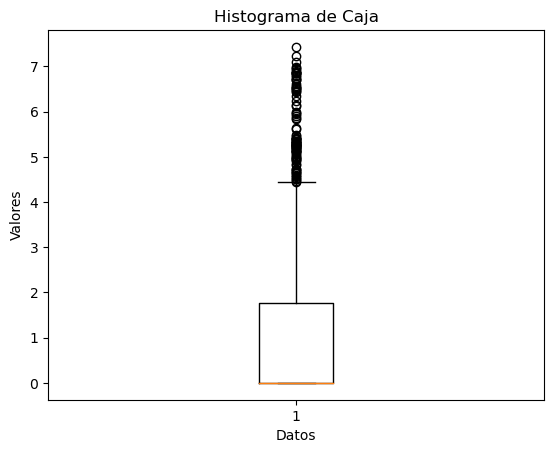

In [7]:
fig, ax = plt.subplots()

# Crear el histograma de caja
ax.boxplot(df['Band_gap'])

# Configurar etiquetas y título
ax.set_xlabel('Datos')
ax.set_ylabel('Valores')
ax.set_title('Histograma de Caja')

# Mostrar el histograma de caja
plt.show()

In [8]:
df['E_above_hull'].describe()

count    1823.000000
mean        0.260187
std         0.373125
min         0.000000
25%         0.000183
50%         0.091459
75%         0.390916
max         3.233293
Name: E_above_hull, dtype: float64

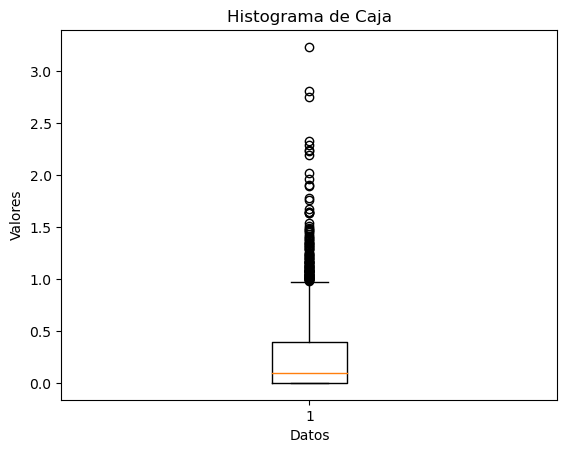

In [9]:
fig, ax = plt.subplots()

# Crear el histograma de caja
ax.boxplot(df['E_above_hull'])

# Configurar etiquetas y título
ax.set_xlabel('Datos')
ax.set_ylabel('Valores')
ax.set_title('Histograma de Caja')

# Mostrar el histograma de caja
plt.show()

In [10]:
df['Formation_energy_per_atom'].describe()

count    1823.000000
mean       -2.201288
std         0.895471
min        -3.983189
25%        -2.894808
50%        -2.311331
75%        -1.548328
max         1.669440
Name: Formation_energy_per_atom, dtype: float64

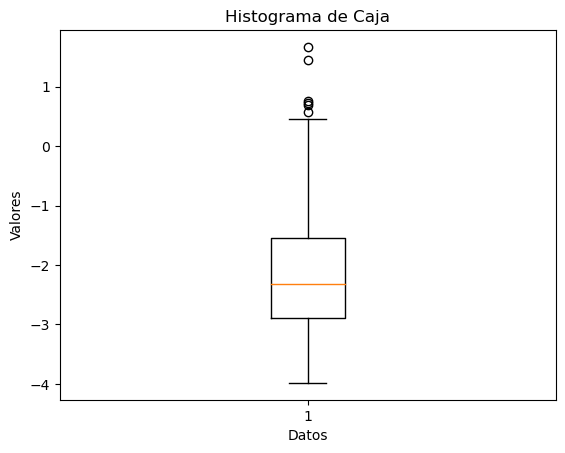

In [11]:
fig, ax = plt.subplots()

# Crear el histograma de caja
ax.boxplot(df['Formation_energy_per_atom'])

# Configurar etiquetas y título
ax.set_xlabel('Datos')
ax.set_ylabel('Valores')
ax.set_title('Histograma de Caja')

# Mostrar el histograma de caja
plt.show()

In [12]:
df['Energy_per_atom'].describe()

count    1823.000000
mean       -6.197696
std         1.605905
min       -10.627792
25%        -7.412291
50%        -6.329622
75%        -4.963690
max        -1.815671
Name: Energy_per_atom, dtype: float64

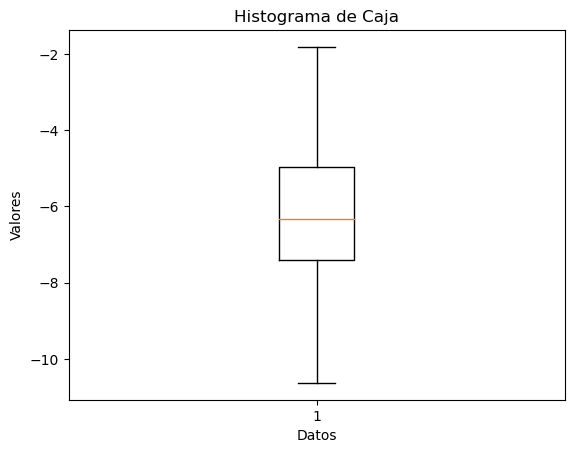

In [13]:
fig, ax = plt.subplots()

# Crear el histograma de caja
ax.boxplot(df['Energy_per_atom'])

# Configurar etiquetas y título
ax.set_xlabel('Datos')
ax.set_ylabel('Valores')
ax.set_title('Histograma de Caja')

# Mostrar el histograma de caja
plt.show()

$$ Primero\ para\ el\ Band\ Gap\ $$

$$ Para\ las\ perovskitas\ A2BB'X6\ $$

In [14]:
X_train1, X_test1, y_train1, y_test1, y_mean1, y_std1 = Dataset(NsitesTrue = True, Nsites = 10, Target = 'Band_gap', Norm = True)

In [15]:
gbr1 = GridSearchCV(GradientBoostingRegressor (),{'n_estimators': [100,10,3],'max_depth': [8], 'min_samples_split': [2], 'learning_rate': [0.1],
    'loss': ['squared_error'], 'random_state':[0,1,2]}, cv=5,n_jobs=-1, verbose = 3)
gbr1.fit(X_train1, y_train1) #Entrenamos el modelo
model1 = gbr1.best_estimator_ #Nos quedamos con el mejor modelo

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Primero vemos las metricas
Model| R2 sq on train set: 0.9985
Model| R2 sq on test set: 0.5709
Model| MSE on test set: 1.5555
Model| MAE on test set: 0.7650
Ahora lo que vemos son la diferencia entre el valor real y el predicho


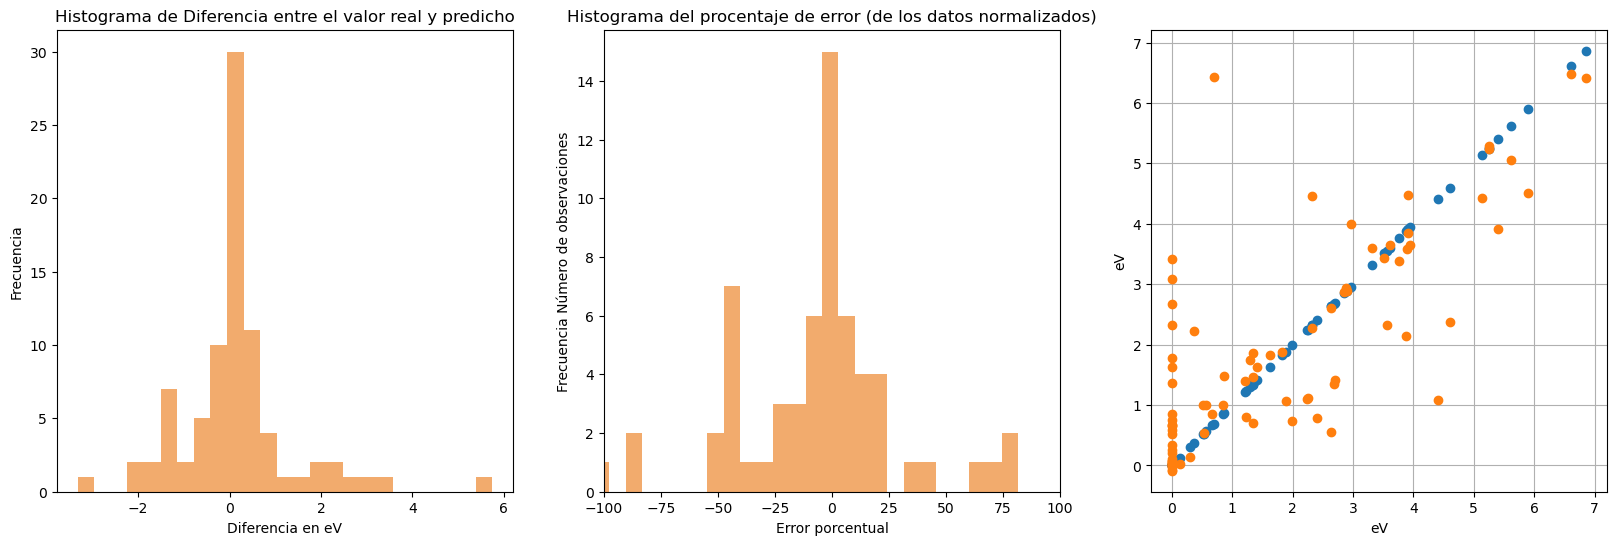

In [16]:
metrica(model1, X_train1, y_train1, X_test1, y_test1, y_mean1, y_std1, DataNorm = True)

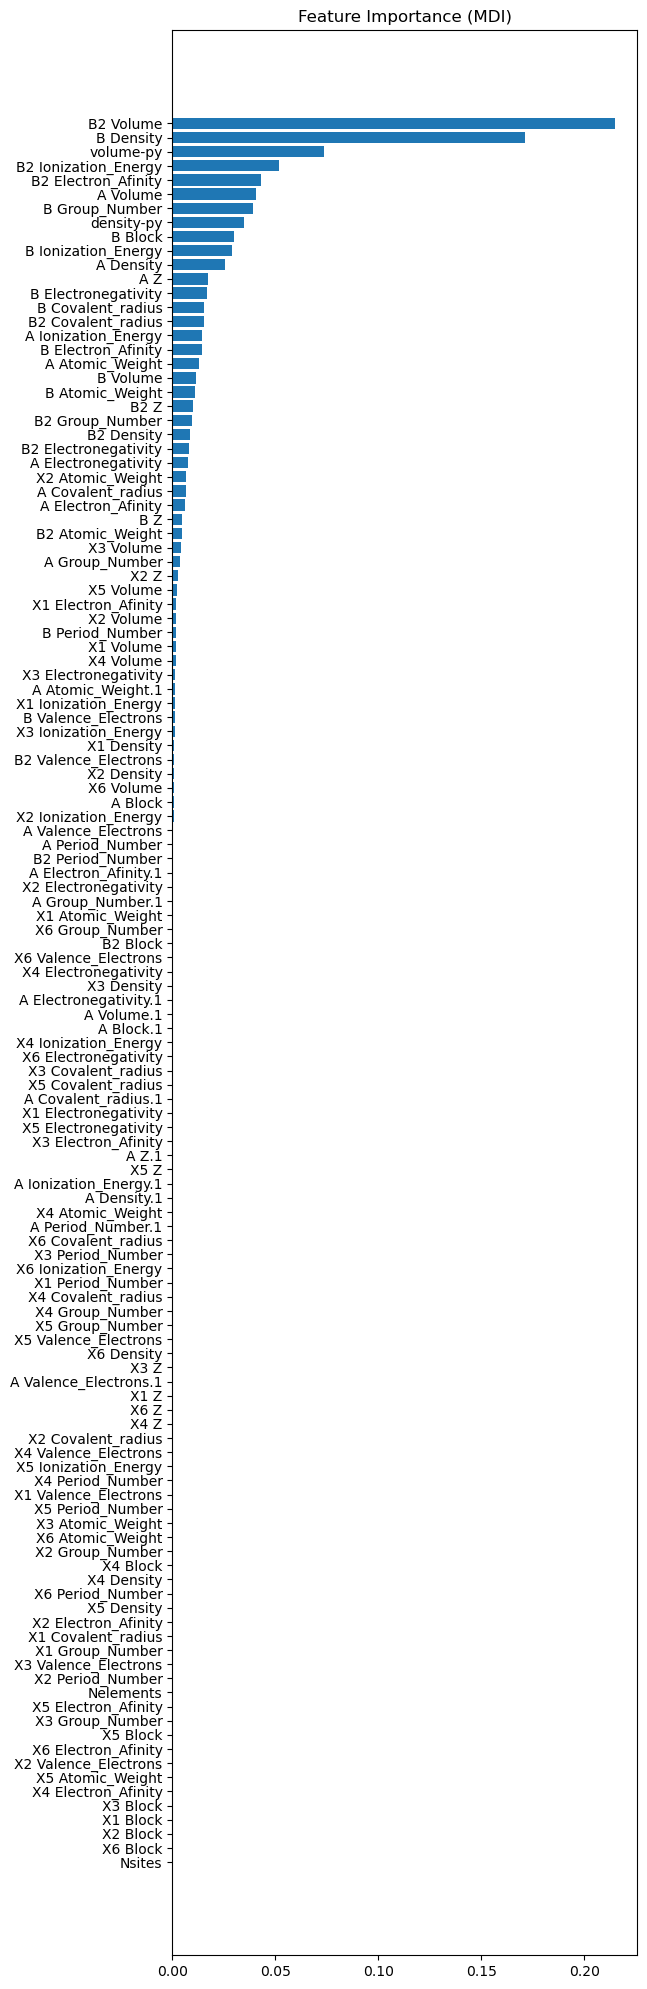

In [17]:
FeatureIm(model1, X_train1)

$$ Para\ las\ perovskitas\ ABX3\ $$

In [18]:
X_train2, X_test2, y_train2, y_test2, y_mean2, y_std2 = Dataset(NsitesTrue = True, Nsites = 5, Target = 'Band_gap', Norm = True)
#Para poder obtener esta metrica se necesita desabilitar la linea de df = shuffle(df, random_state=2) 
#la funcion Dataset

In [19]:
grid2 = GridSearchCV (RandomForestRegressor(),{'max_depth':[100], 'random_state':[0,1,2], 'criterion':['squared_error']
                                             }, cv=5, refit=True, verbose=3)
grid2.fit(X_train2,y_train2)
#Aqui lo que hacemos es quedarnos con el mejor metodo, el que da mejores resultados, lo llamamos en este caso: model1
model2 = grid2.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.645 total time=   0.6s
[CV 2/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.629 total time=   0.6s
[CV 3/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.366 total time=   0.6s
[CV 4/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.593 total time=   0.6s
[CV 5/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.580 total time=   0.6s
[CV 1/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.635 total time=   0.6s
[CV 2/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.650 total time=   0.6s
[CV 3/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.393 total time=   0.6s
[CV 4/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.574 total time=   0.6s
[CV 5/5] END criterion=squared_

Primero vemos las metricas
Model| R2 sq on train set: 0.9453
Model| R2 sq on test set: 0.6244
Model| MSE on test set: 0.6330
Model| MAE on test set: 0.4496
Ahora lo que vemos son la diferencia entre el valor real y el predicho


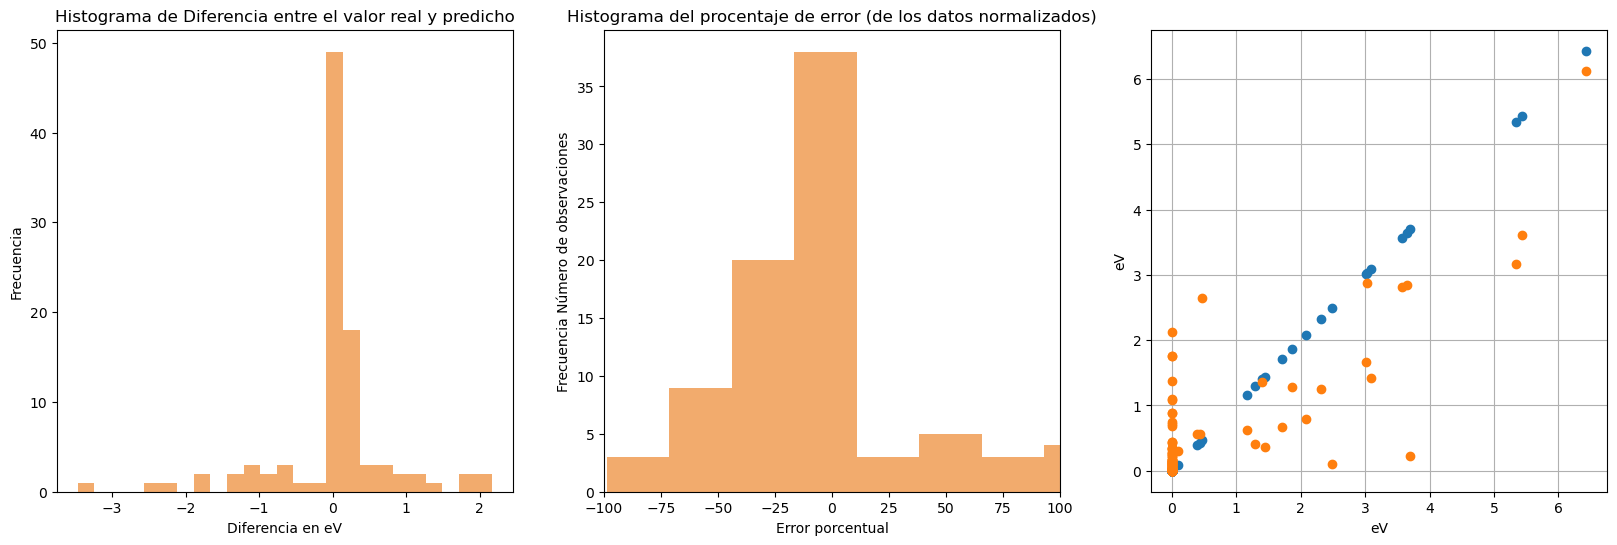

In [20]:
metrica(model2, X_train2, y_train2, X_test2, y_test2, y_mean2, y_std2, DataNorm = True)

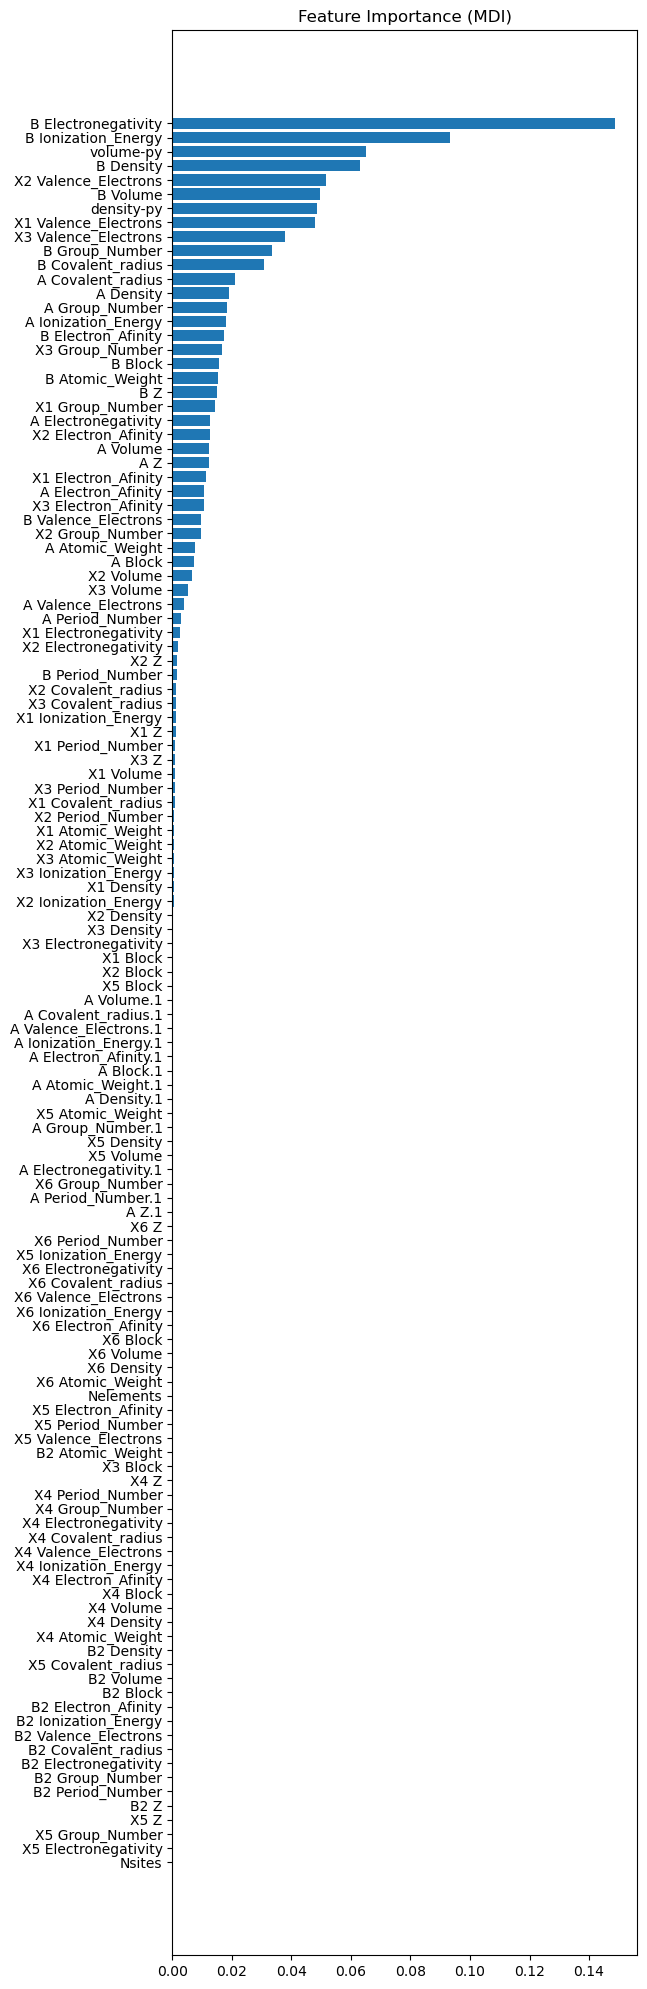

In [21]:
FeatureIm(model2, X_train2)

$$ Para\ las\ perovskitas\ ABX3\ y\ A2BB'X6 $$

In [22]:
X_train3, X_test3, y_train3, y_test3, y_mean3, y_std3 = Dataset(NsitesTrue = False, Nsites = 5, Target = 'Band_gap', Norm = True)

In [23]:
grid3 = GridSearchCV (RandomForestRegressor(),{'max_depth':[100], 'random_state':[0,1,2], 'criterion':['squared_error']
                                             }, cv=5, refit=True, verbose=3)
grid3.fit(X_train3,y_train3)
#Aqui lo que hacemos es quedarnos con el mejor metodo, el que da mejores resultados, lo llamamos en este caso: model1
model3 = grid3.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.734 total time=   1.8s
[CV 2/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.649 total time=   1.8s
[CV 3/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.608 total time=   1.8s
[CV 4/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.622 total time=   2.0s
[CV 5/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.578 total time=   2.0s
[CV 1/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.742 total time=   1.9s
[CV 2/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.635 total time=   2.1s
[CV 3/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.625 total time=   1.9s
[CV 4/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.625 total time=   2.0s
[CV 5/5] END criterion=squared_

Primero vemos las metricas
Model| R2 sq on train set: 0.9530
Model| R2 sq on test set: 0.7656
Model| MSE on test set: 0.2555
Model| MAE on test set: 0.3418
Ahora lo que vemos son la diferencia entre el valor real y el predicho


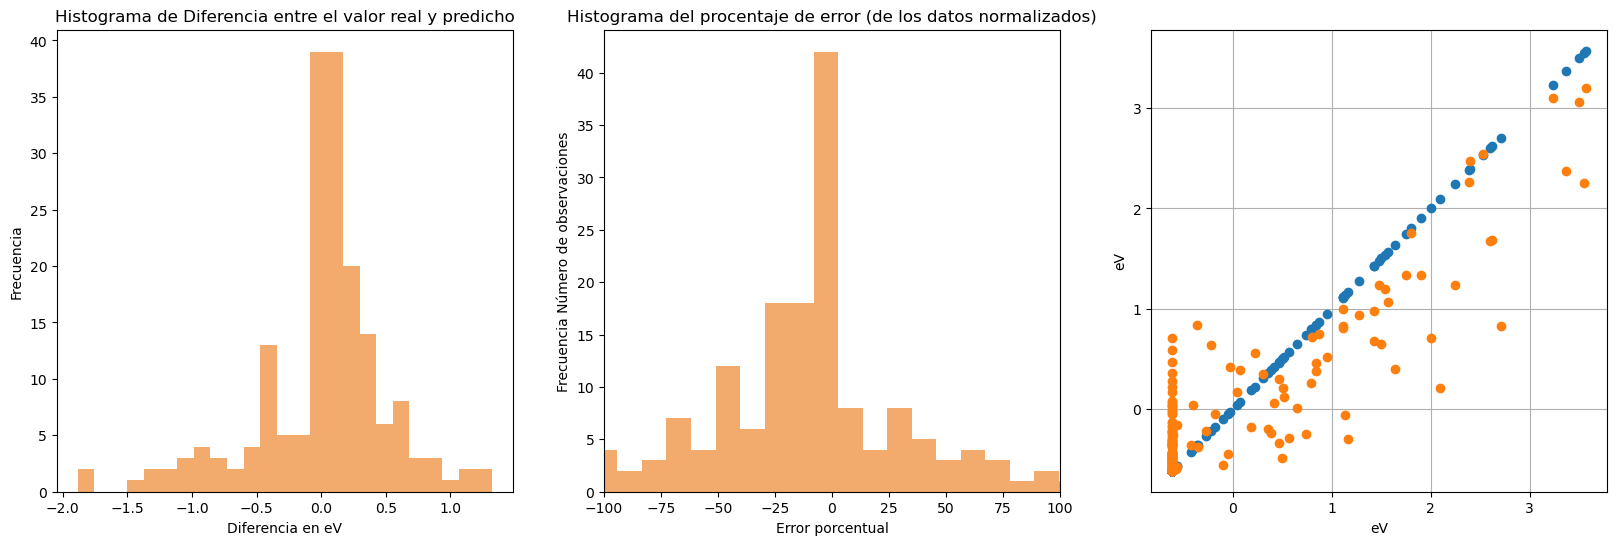

In [24]:
metrica(model3, X_train3, y_train3, X_test3, y_test3, y_mean3, y_std3, DataNorm = False)
#Para poder obtener esta metrica se necesita desabilitar la linea de df = shuffle(df, random_state=2) 
#la funcion Dataset

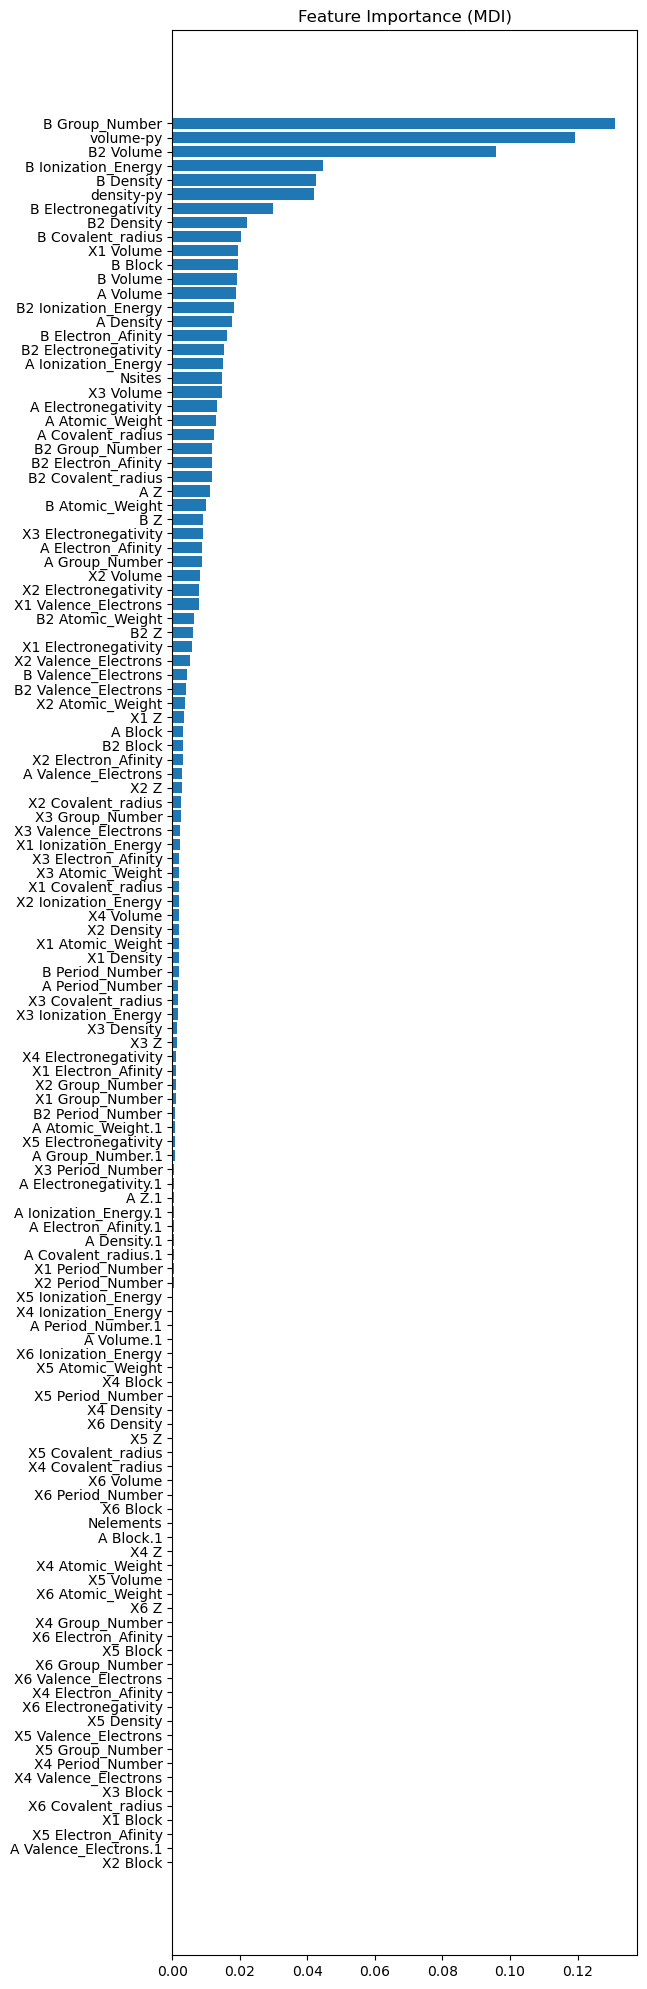

In [25]:
FeatureIm(model3, X_train3)

$$ Ahora\ para\ predecir\ la\ energía\ de\ E\ above\ hull\ $$

$$ Para\ las\ perovskitas\ A2BB'X6 $$

In [26]:
X_train4, X_test4, y_train4, y_test4, y_mean4, y_std4 = Dataset(NsitesTrue = True, Nsites = 10, Target = 'E_above_hull', Norm = True)

In [27]:
kernel = 5*RBF(1.0)+10*RBF(2.0)+15*RBF(3.0) #Definimos que tipo de kernel usar, en este caso uno contante de 15 y 2 tipo RBF
gpr4 = make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel = kernel))
gpr4.fit(X_train4, y_train4) #Entrenamos el modelo
model4 = gpr4

Primero vemos las metricas
Model| R2 sq on train set: 1.0000
Model| R2 sq on test set: -0.0348
Model| MSE on test set: 0.0191
Model| MAE on test set: 0.0884
Ahora lo que vemos son la diferencia entre el valor real y el predicho


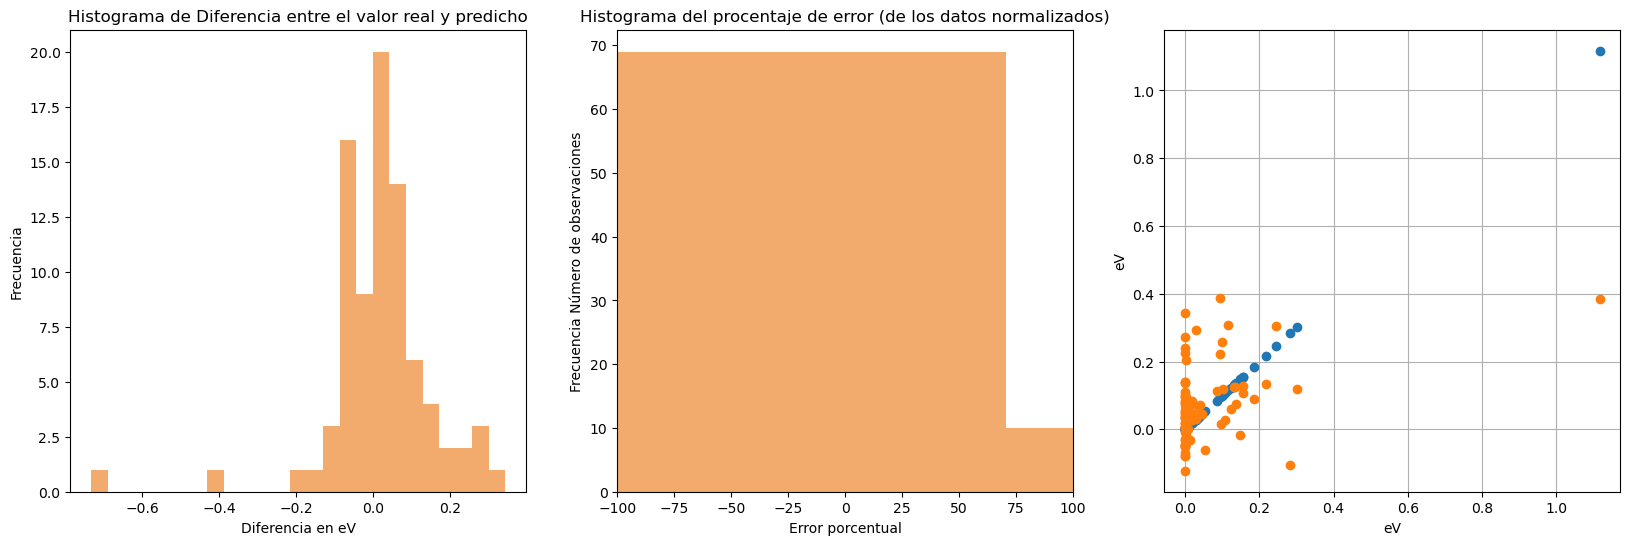

In [28]:
metrica(model4, X_train4, y_train4, X_test4, y_test4, y_mean4, y_std4, DataNorm = True)

$$ Para\ las\ Perovskitas\ ABX3\ $$

In [29]:
X_train5, X_test5, y_train5, y_test5,y_mean5, y_std5 = Dataset(NsitesTrue = True, Nsites = 5, Target = 'E_above_hull', Norm = True)
#Este se obtiene al quitar la linea de codigo: 

In [30]:
grid5 = GridSearchCV(GradientBoostingRegressor (),{'n_estimators': [100,10,3], 'max_depth': [8], 'min_samples_split': [2], 'learning_rate': [0.1],
    'loss': ['squared_error'], 'random_state':[0,1,2]}, cv=5, verbose = 3)
grid5.fit(X_train5, y_train5) #Entrenamos el modelo
model5 = grid5.best_estimator_ #Nos quedamos con el mejor modelo

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.612 total time=   0.6s
[CV 2/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.531 total time=   0.7s
[CV 3/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.623 total time=   0.8s
[CV 4/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.529 total time=   0.7s
[CV 5/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.650 total time=   0.7s
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=1;, score=0.610 total time=   0.7s
[CV 2/5] END learning_rate=0

Primero vemos las metricas
Model| R2 sq on train set: 0.9995
Model| R2 sq on test set: 0.6562
Model| MSE on test set: 0.0658
Model| MAE on test set: 0.1504
Ahora lo que vemos son la diferencia entre el valor real y el predicho


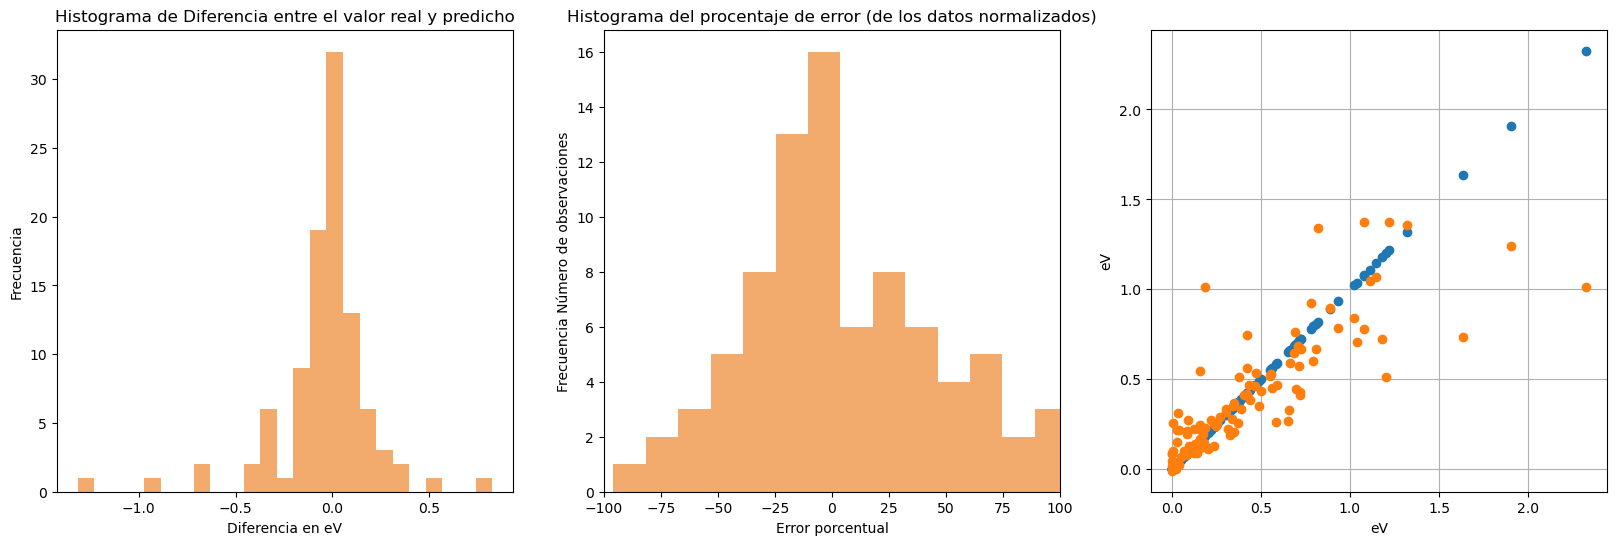

In [31]:
metrica(model5, X_train5, y_train5, X_test5, y_test5, y_mean5, y_std5, DataNorm = True)

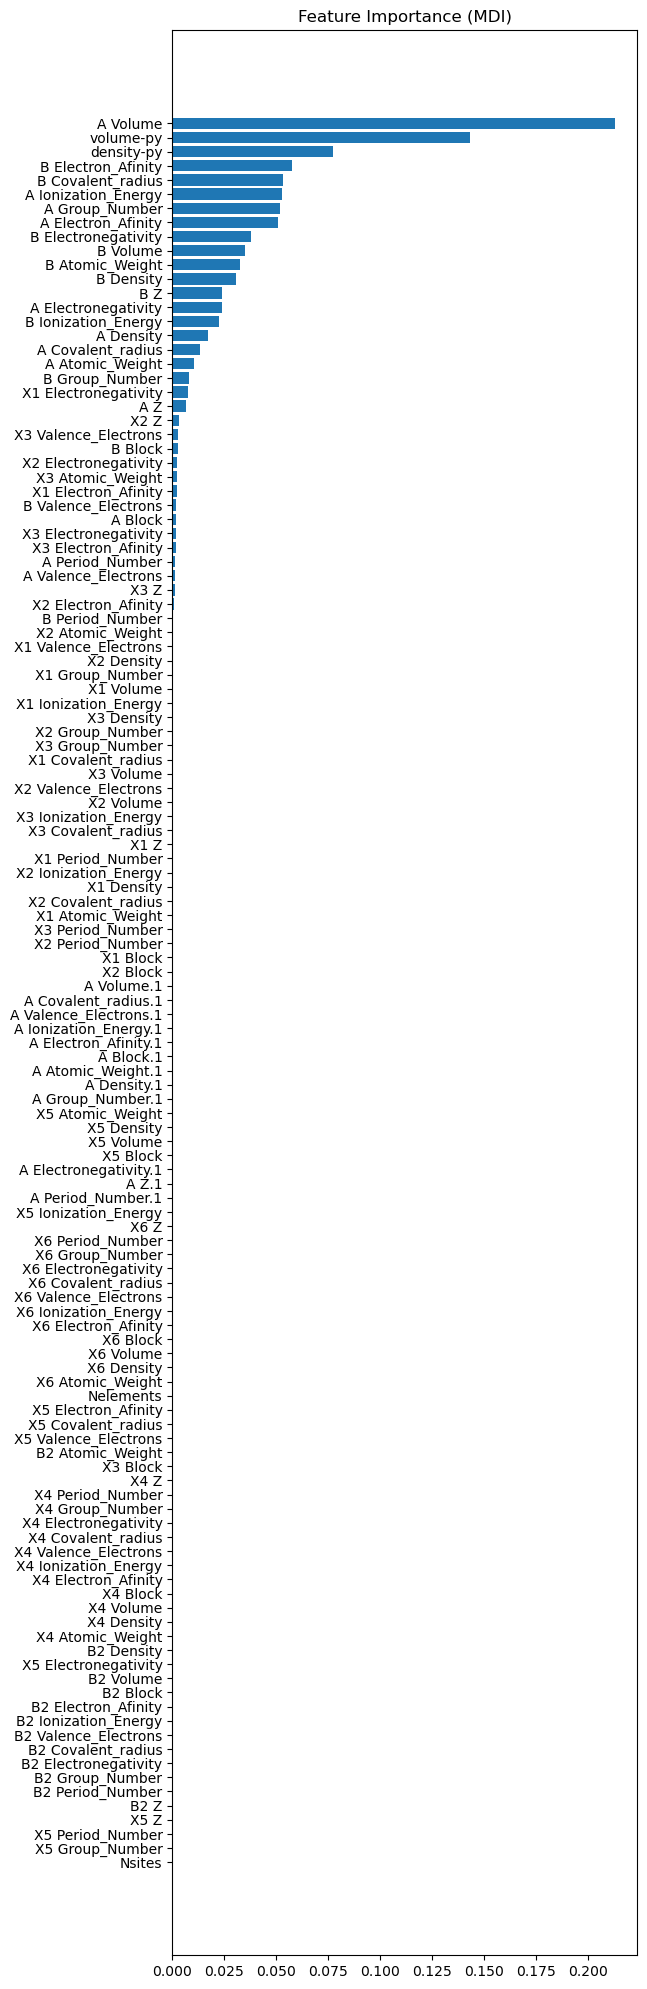

In [32]:
FeatureIm(model5, X_train5)

$$ Ahora\ para\ ambas\ tipos\ de\ Perovskitas\ $$

In [33]:
X_train6, X_test6, y_train6, y_test6, y_mean6, y_std6 = Dataset(NsitesTrue = False, Nsites = 5, Target = 'E_above_hull', Norm = True)
#Este resultado se obtiene al quitar: df = shuffle(df, random_state=2)

In [34]:
grid6 = GridSearchCV(GradientBoostingRegressor (),{'n_estimators': [100,10,3], 'max_depth': [8], 'min_samples_split': [2], 'learning_rate': [0.1],
    'loss': ['squared_error'], 'random_state':[0,1,2]}, cv=5, verbose = 3)
grid6.fit(X_train6, y_train6) #Entrenamos el modelo
model6 = grid6.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.581 total time=   1.8s
[CV 2/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.437 total time=   1.7s
[CV 3/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.602 total time=   1.7s
[CV 4/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.343 total time=   1.7s
[CV 5/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.649 total time=   1.6s
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=1;, score=0.588 total time=   1.7s
[CV 2/5] END learning_rate=0

Primero vemos las metricas
Model| R2 sq on train set: 0.9978
Model| R2 sq on test set: 0.8051
Model| MSE on test set: 0.0252
Model| MAE on test set: 0.0937
Ahora lo que vemos son la diferencia entre el valor real y el predicho


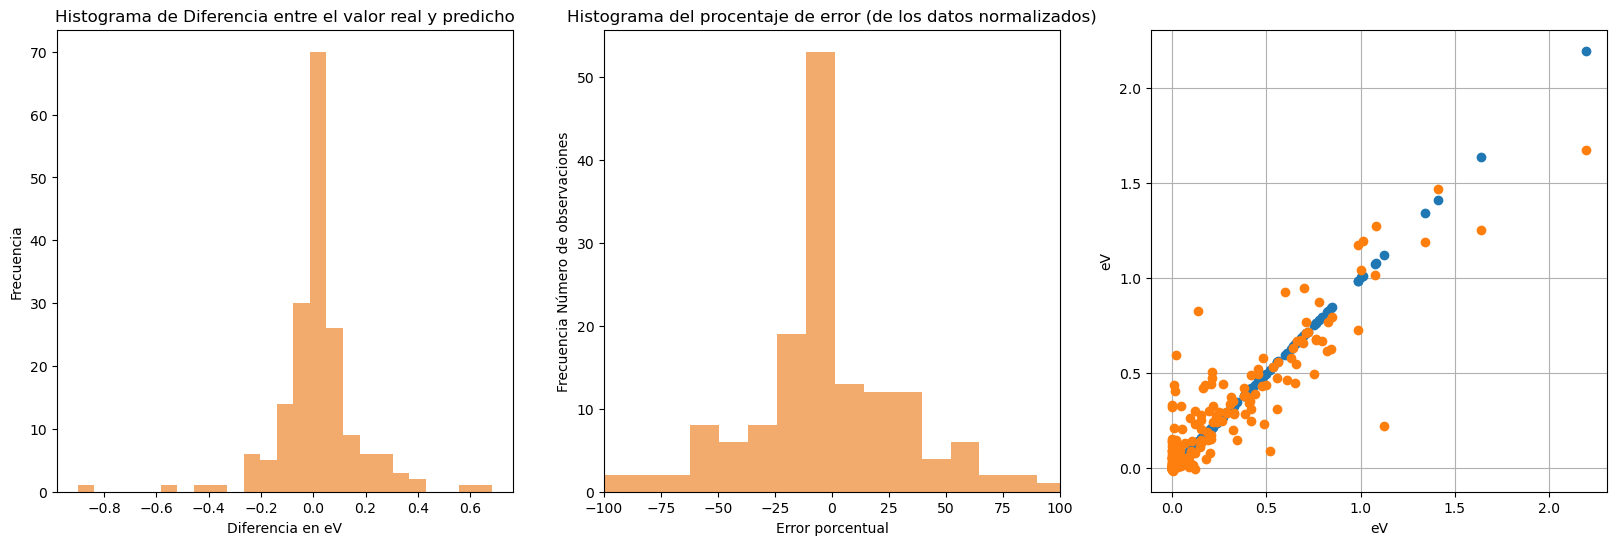

In [35]:
metrica(model6, X_train6, y_train6, X_test6, y_test6, y_mean6, y_std6, DataNorm = True)

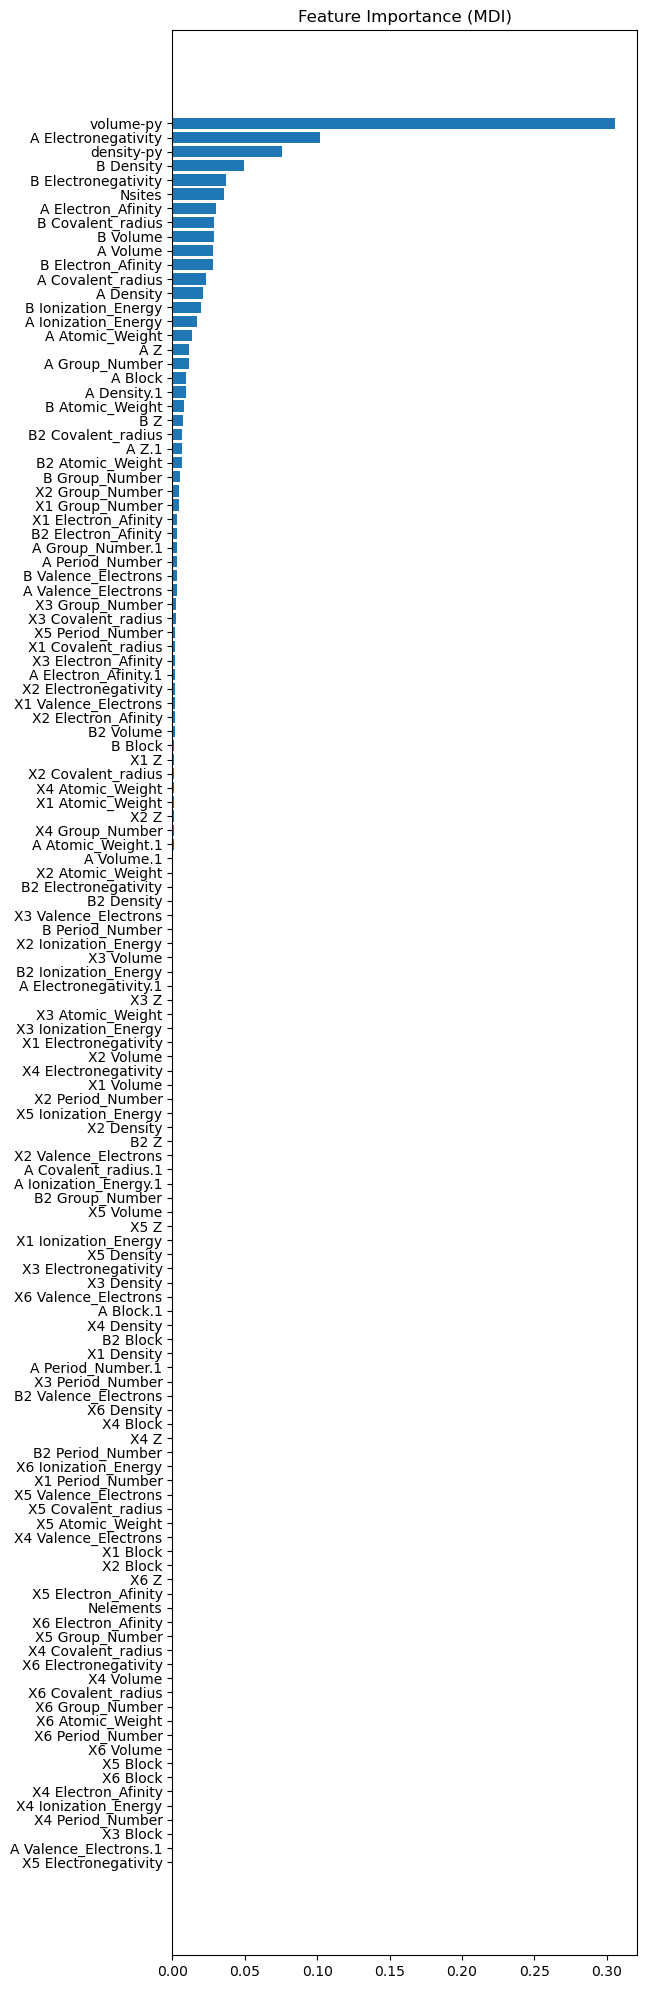

In [36]:
FeatureIm(model6, X_train6)

$$ Ahora\ para\ predecir\ la\ Energía\ Total\ por\ atomo$$

$$ Para\ las\ perovskitas\ A2BB'X6 $$

In [37]:
X_train7, X_test7, y_train7, y_test7, y_mean7, y_std7 = Dataset(NsitesTrue = True, Nsites = 10, Target = 'Energy_per_atom', Norm = True)

In [38]:
steps1 = [('scaler', StandardScaler()), ('SVM', SVR())]
pipeline1 = Pipeline(steps1) 
svm1 = GridSearchCV(pipeline1, param_grid= {'SVM__C':[100], 'SVM__gamma':['auto'], 'SVM__kernel': ['rbf'],
                                           'SVM__epsilon':[0.001]},cv = 5, refit=True,verbose=3, n_jobs = -1)
svm1.fit(X_train7,y_train7)
#Aqui lo que hacemos es quedarnos con el mejor metodo, el que da mejores resultados, lo llamamos en este caso: model1
model7 = svm1.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Primero vemos las metricas
Model| R2 sq on train set: 0.9951
Model| R2 sq on test set: 0.9481
Model| MSE on test set: 0.1162
Model| MAE on test set: 0.2161
Ahora lo que vemos son la diferencia entre el valor real y el predicho


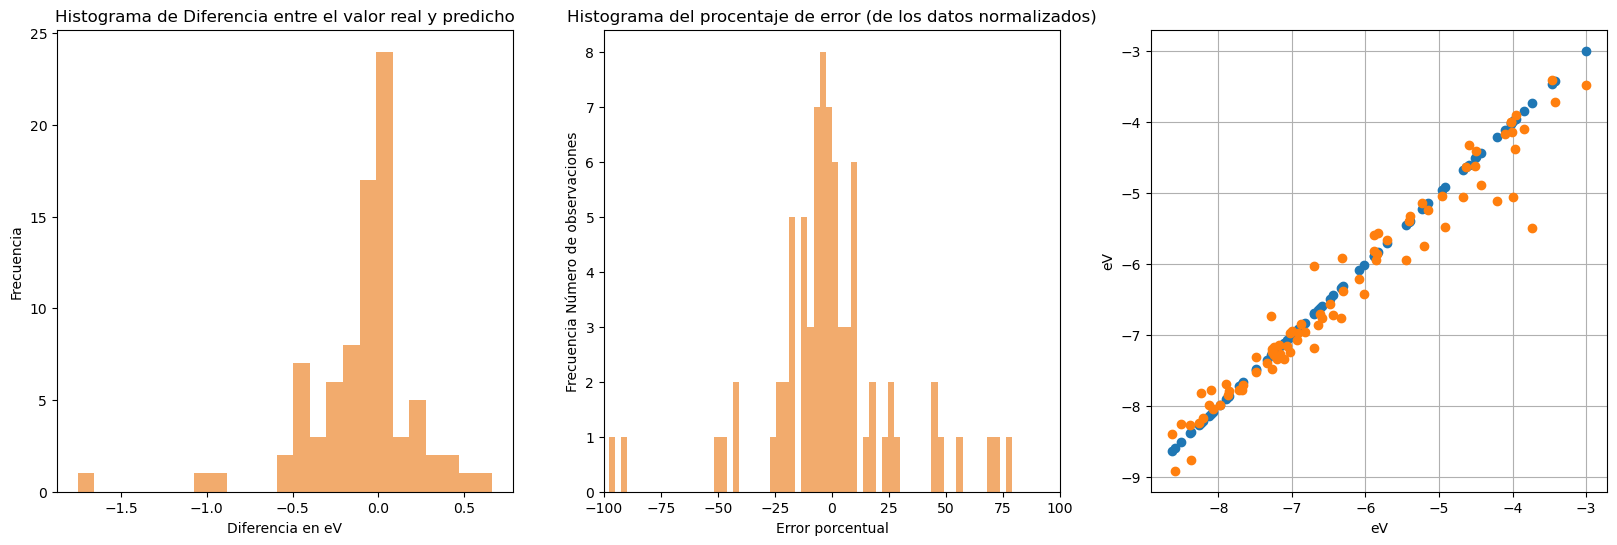

In [39]:
metrica(model7, X_train7, y_train7, X_test7, y_test7, y_mean7, y_std7, DataNorm = True)

FeatureIm(model7, X_train7)

$$ Para\ las\ perovskitas\ ABX3 $$

In [40]:
X_train8, X_test8, y_train8, y_test8, y_mean8, y_std8 = Dataset(NsitesTrue = True, Nsites = 5, Target = 'Energy_per_atom', Norm = True)

In [41]:
gbr8 = GridSearchCV(GradientBoostingRegressor (),{'n_estimators': [100,10,3], 'max_depth': [8], 'min_samples_split': [2], 'learning_rate': [0.1],
    'loss': ['squared_error'], 'random_state':[0,1,2]}, cv=5, verbose = 3)
#loss = 'ls', este es least squares
gbr8.fit(X_train8, y_train8) #Entrenamos el modelo
model8 = gbr8.best_estimator_ #Nos quedamos con el mejor modelo

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.893 total time=   0.7s
[CV 2/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.905 total time=   0.7s
[CV 3/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.943 total time=   0.6s
[CV 4/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.898 total time=   0.7s
[CV 5/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.913 total time=   0.7s
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=1;, score=0.899 total time=   0.6s
[CV 2/5] END learning_rate=0

Primero vemos las metricas
Model| R2 sq on train set: 1.0000
Model| R2 sq on test set: 0.9545
Model| MSE on test set: 0.1147
Model| MAE on test set: 0.2416
Ahora lo que vemos son la diferencia entre el valor real y el predicho


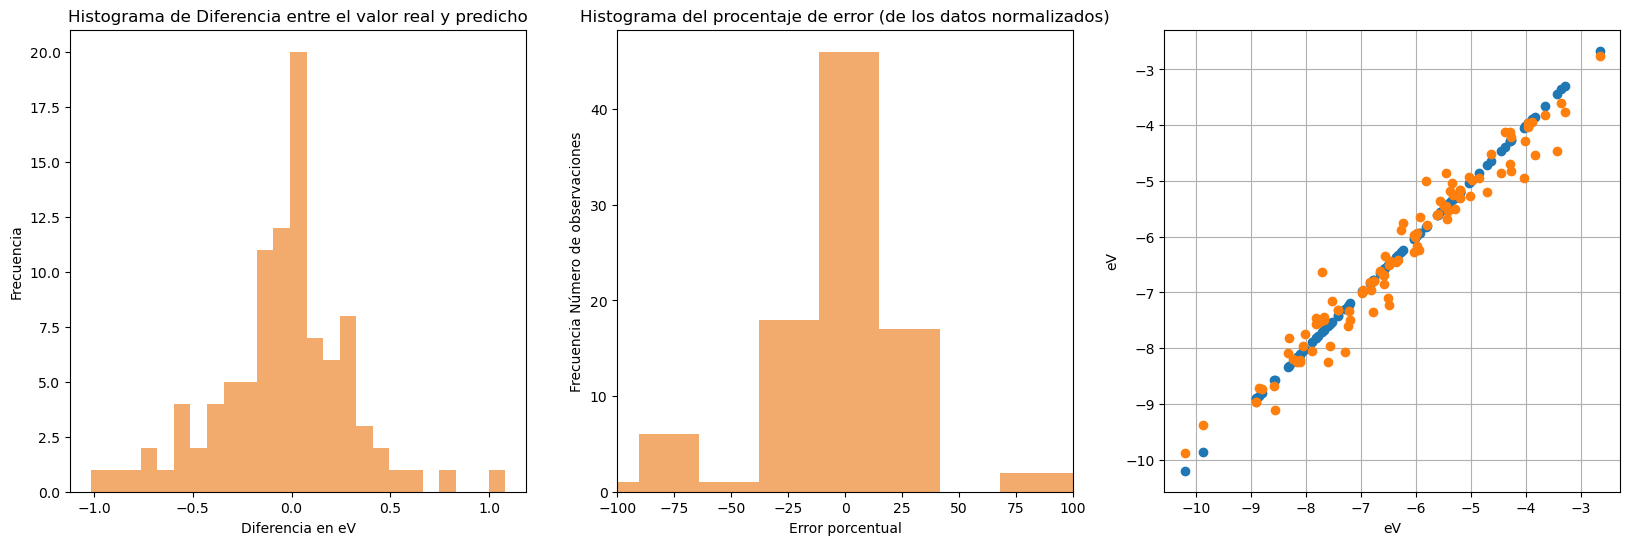

In [42]:
metrica(model8, X_train8, y_train8, X_test8, y_test8, y_mean8, y_std8, DataNorm = True)

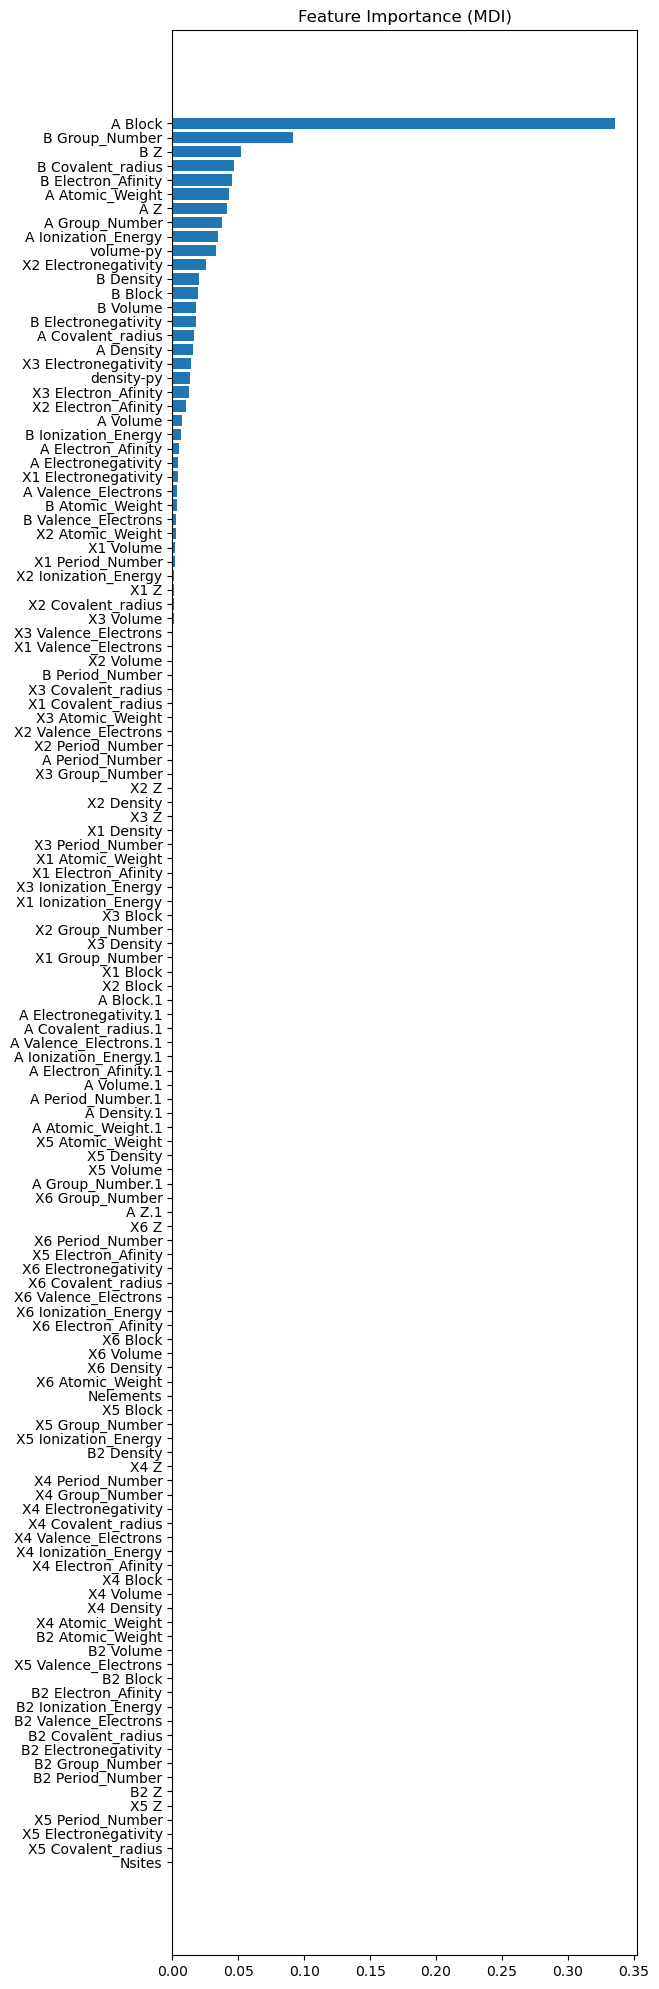

In [43]:
FeatureIm(model8, X_train8)

$$ Para\ ambos\ tipos\ de\ perovskitas\ $$

In [44]:
X_train9, X_test9, y_train9, y_test9, y_mean9, y_std9 = Dataset(NsitesTrue = False, Nsites = 5, Target = 'Energy_per_atom', Norm = True)
#Este resultado se obtiene al quitar: df = shuffle(df, random_state=2)

In [45]:
gbr9 = GridSearchCV(GradientBoostingRegressor (),{'n_estimators': [100,10,3], 'max_depth': [8], 'min_samples_split': [2], 'learning_rate': [0.1],
    'loss': ['squared_error'], 'random_state':[0,1,2]}, cv=5, verbose = 3)
#loss = 'ls', este es least squares
gbr9.fit(X_train9, y_train9) #Entrenamos el modelo
model9 = gbr9.best_estimator_ #Nos quedamos con el mejor modelo

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.943 total time=   1.7s
[CV 2/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.942 total time=   1.7s
[CV 3/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.956 total time=   1.6s
[CV 4/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.914 total time=   1.7s
[CV 5/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.946 total time=   1.7s
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=1;, score=0.945 total time=   1.7s
[CV 2/5] END learning_rate=0

Primero vemos las metricas
Model| R2 sq on train set: 0.9997
Model| R2 sq on test set: 0.9528
Model| MSE on test set: 0.0423
Model| MAE on test set: 0.1407
Ahora lo que vemos son la diferencia entre el valor real y el predicho


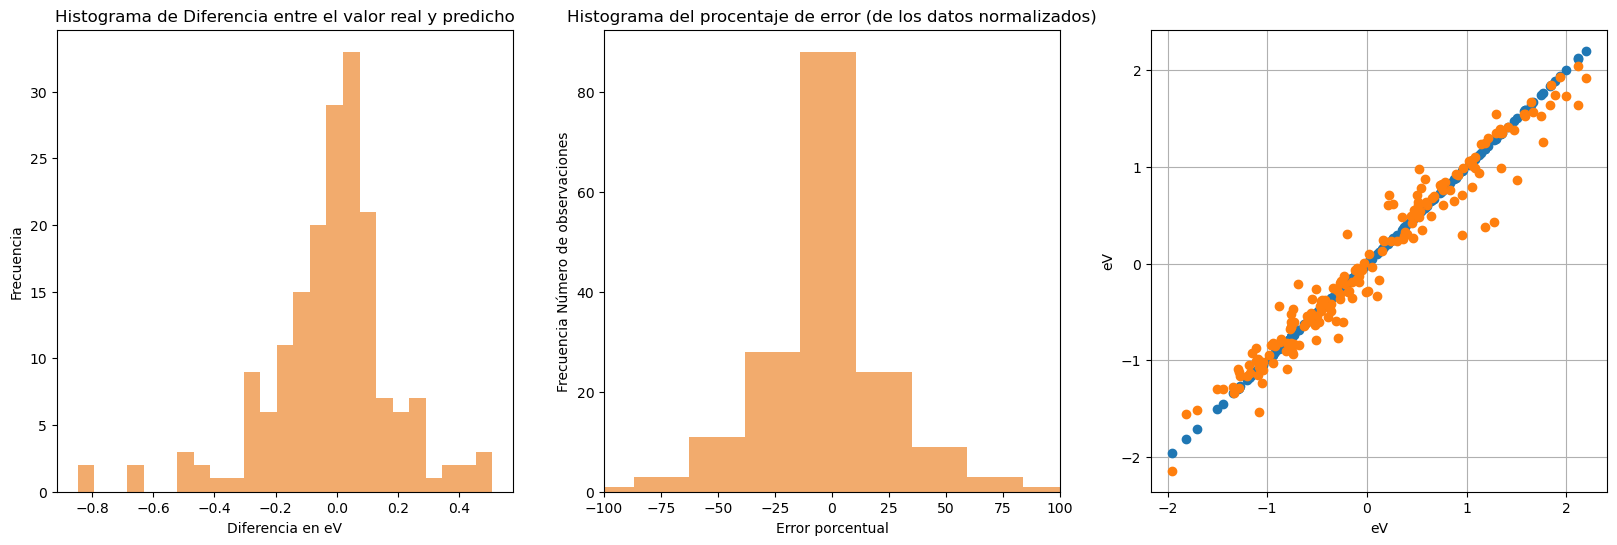

In [46]:
metrica(model9, X_train9, y_train9, X_test9, y_test9, y_mean9, y_std9, DataNorm = False)

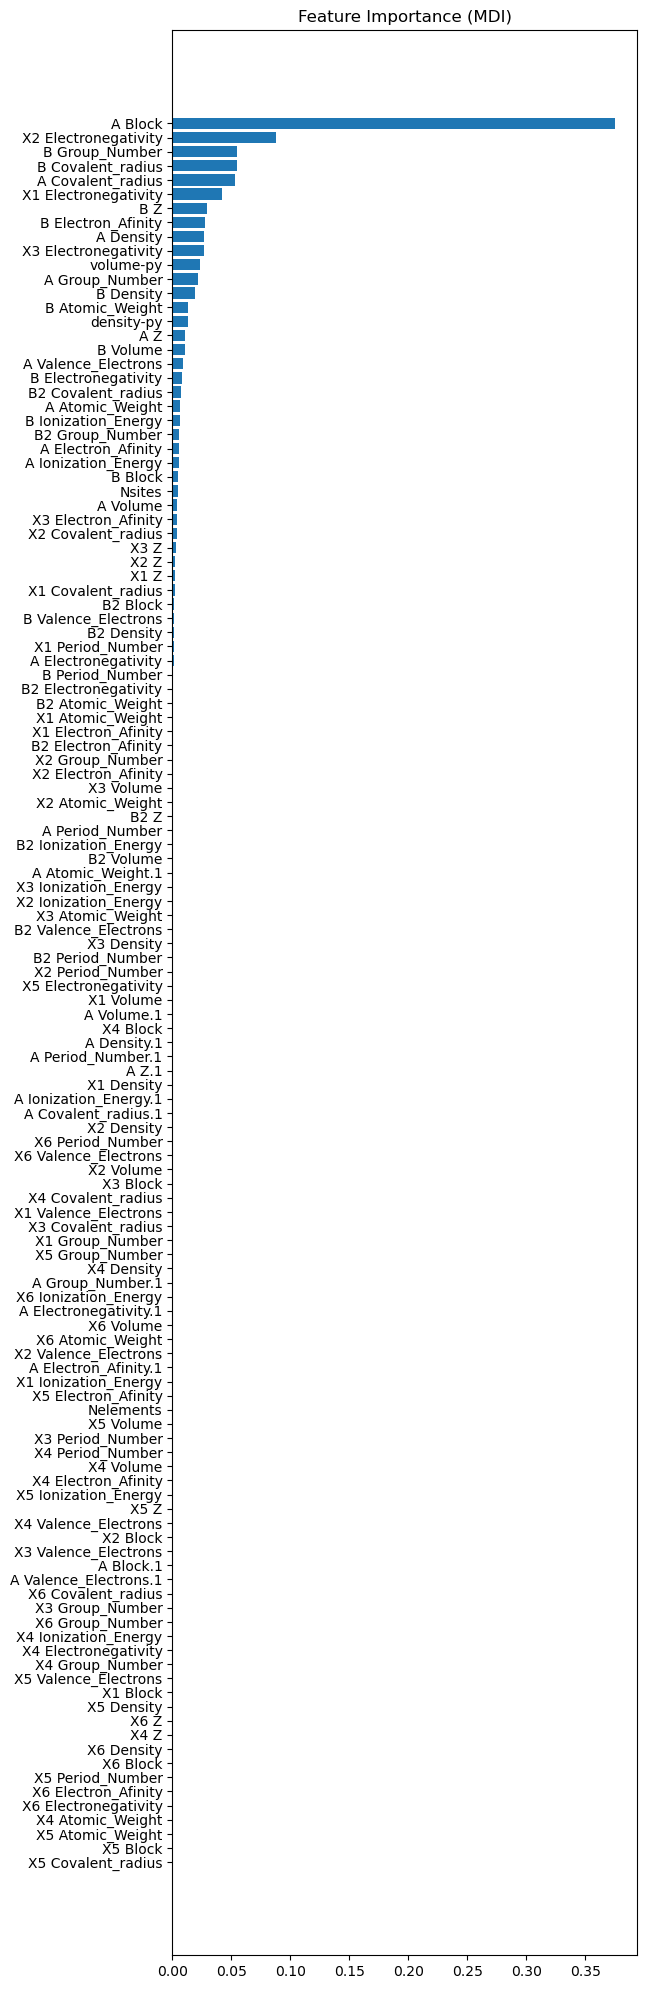

In [47]:
FeatureIm(model9, X_train9)

$$ Ahora\ para\ predecir\ la\ energía\ de\ Formacion\ por\ atomo\$$

$$ Para\ las\ perovskitas\ A2BB'X6 $$

In [48]:
X_train10, X_test10, y_train10, y_test10, y_mean10, y_std10 = Dataset(NsitesTrue = True, Nsites = 10, Target = 'Formation_energy_per_atom', Norm = True)
#Este resultado se obtuvo al quitar: df = shuffle(df, random_state=2)

In [49]:
gbr10 = GridSearchCV(GradientBoostingRegressor (),{'n_estimators': [100,10,3], 'max_depth': [8], 'min_samples_split': [2], 'learning_rate': [0.1],
    'loss': ['squared_error'], 'random_state':[0,1,2]}, cv=5, verbose = 3)
#loss = 'ls', este es least squares
gbr10.fit(X_train10, y_train10) #Entrenamos el modelo
model10 = gbr10.best_estimator_ #Nos quedamos con el mejor modelo

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.851 total time=   0.9s
[CV 2/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.841 total time=   1.0s
[CV 3/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.903 total time=   0.9s
[CV 4/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.892 total time=   0.8s
[CV 5/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.889 total time=   0.8s
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=1;, score=0.858 total time=   0.9s
[CV 2/5] END learning_rate=0

Primero vemos las metricas
Model| R2 sq on train set: 0.9999
Model| R2 sq on test set: 0.8903
Model| MSE on test set: 0.0778
Model| MAE on test set: 0.1624
Ahora lo que vemos son la diferencia entre el valor real y el predicho


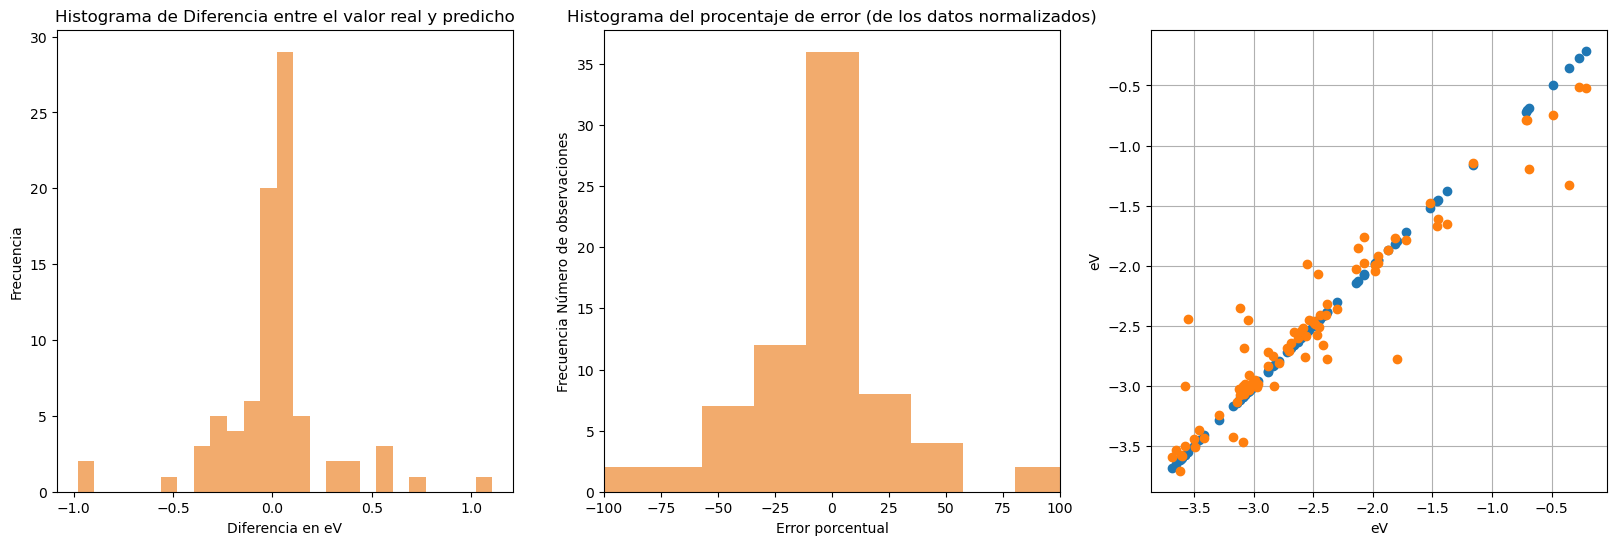

In [50]:
metrica(model10, X_train10, y_train10, X_test10, y_test10, y_mean10, y_std10, DataNorm = True)

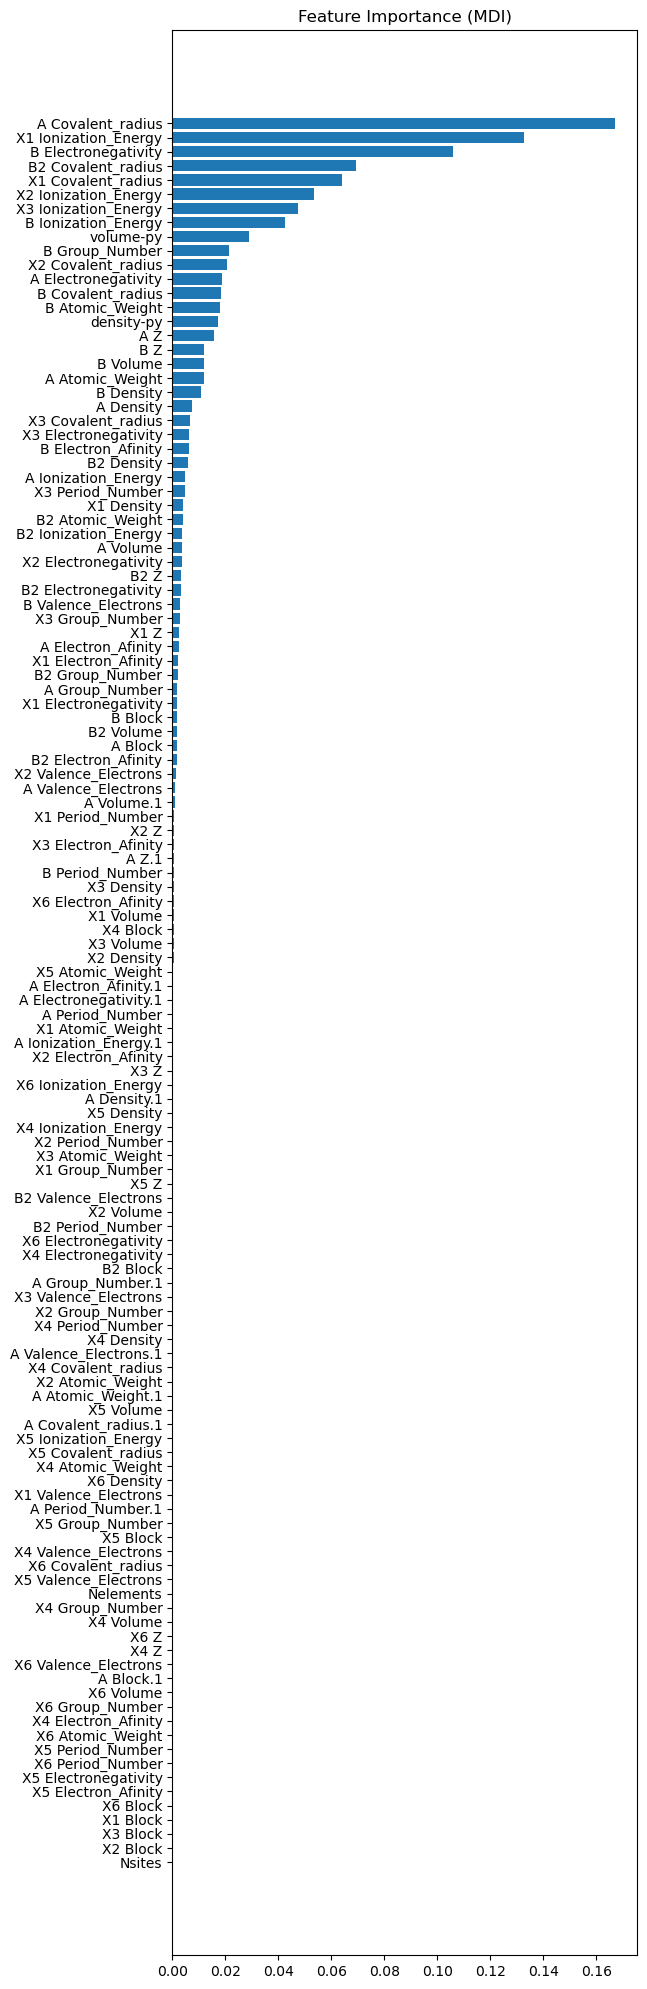

In [51]:
FeatureIm(model10, X_train10)

$$ Para\ las\ perovskitas\ ABX3 $$

In [52]:
X_train11, X_test11, y_train11, y_test11, y_mean11, y_std11 = Dataset(NsitesTrue = True, Nsites = 5, Target = 'Formation_energy_per_atom', Norm = False)

In [53]:
gbr11 = GridSearchCV(GradientBoostingRegressor (),{'n_estimators': [100,10,3], 'max_depth': [8], 'min_samples_split': [2], 'learning_rate': [0.1],
    'loss': ['squared_error'], 'random_state':[0,1,2]}, cv=5, verbose = 3)
#loss = 'ls', este es least squares
gbr11.fit(X_train11, y_train11) #Entrenamos el modelo
model11 = gbr11.best_estimator_ #Nos quedamos con el mejor modelo

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.727 total time=   0.7s
[CV 2/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.791 total time=   0.7s
[CV 3/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.874 total time=   0.7s
[CV 4/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.858 total time=   0.7s
[CV 5/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=0;, score=0.718 total time=   0.7s
[CV 1/5] END learning_rate=0.1, loss=squared_error, max_depth=8, min_samples_split=2, n_estimators=100, random_state=1;, score=0.726 total time=   0.7s
[CV 2/5] END learning_rate=0

Primero vemos las metricas
Model| R2 sq on train set: 0.9999
Model| R2 sq on test set: 0.9037
Model| MSE on test set: 0.0756
Model| MAE on test set: 0.1879
Ahora lo que vemos son la diferencia entre el valor real y el predicho


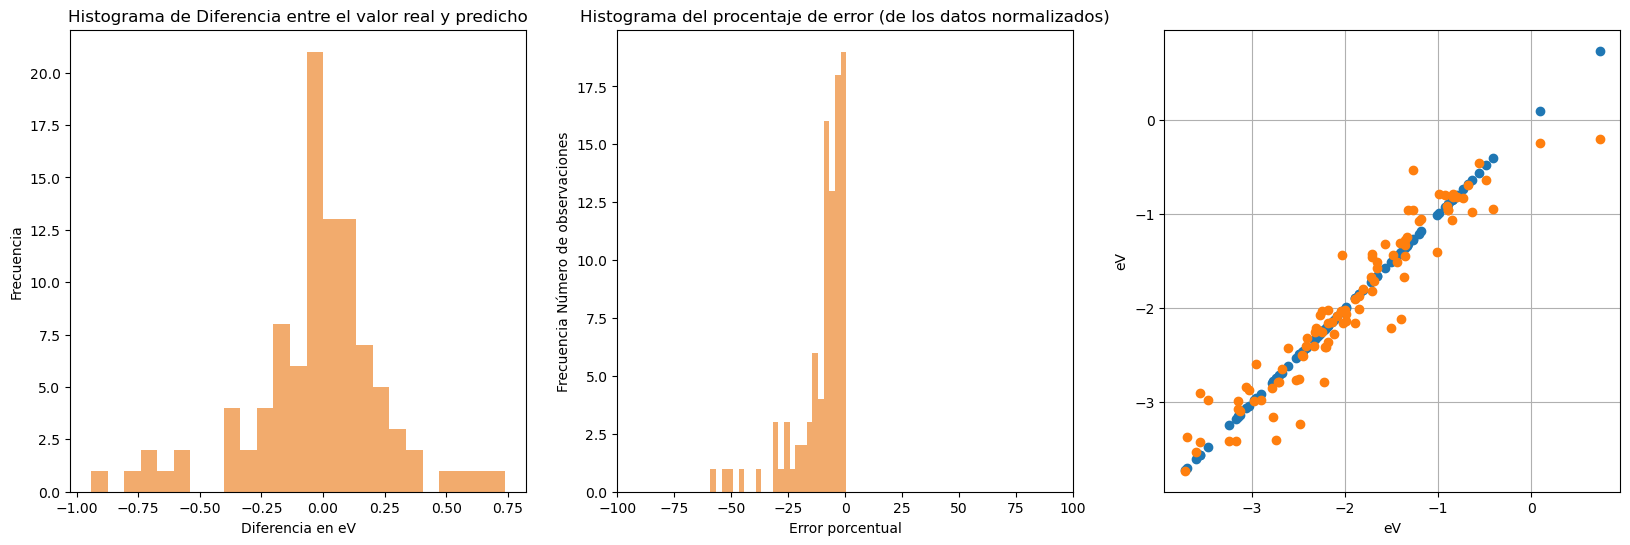

In [54]:
metrica(model11, X_train11, y_train11, X_test11, y_test11, y_mean11, y_std11, DataNorm = False)

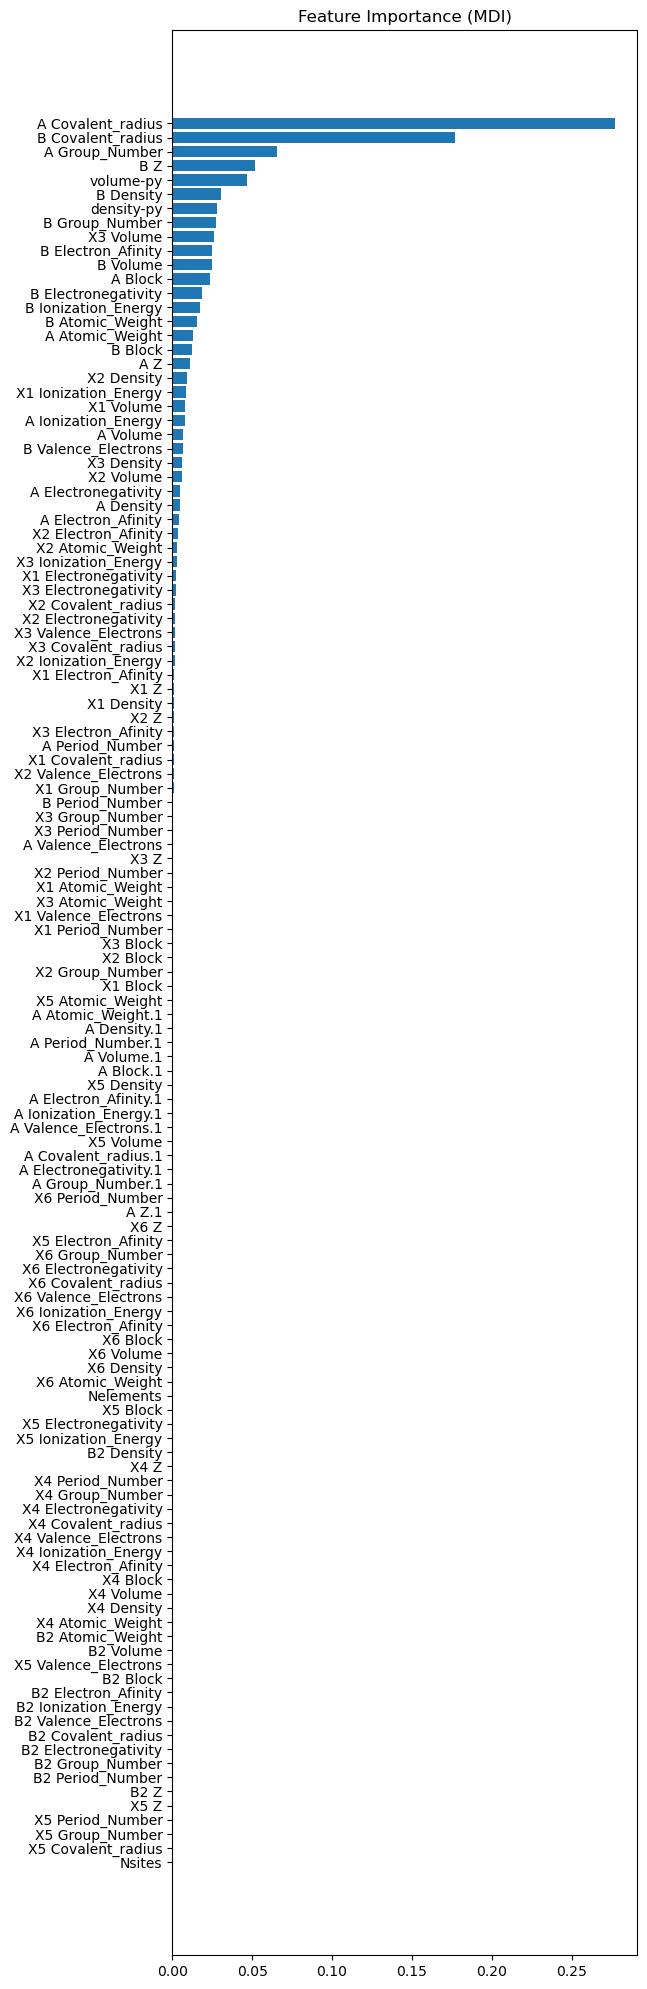

In [55]:
FeatureIm(model11, X_train11)

$$ Para\ ambos\ tipo\ de\ perovskitas\ $$

In [56]:
X_train12, X_test12, y_train12, y_test12, y_mean12, y_std12 = Dataset(NsitesTrue = False, Nsites = 5, Target = 'Formation_energy_per_atom', Norm = True)

In [57]:
grid12 = GridSearchCV (RandomForestRegressor(),{'max_depth':[100], 'random_state':[0,1,2], 'criterion':['squared_error']
                                             }, cv=5, refit=True, verbose=3)
grid12.fit(X_train12,y_train12)
#Aqui lo que hacemos es quedarnos con el mejor metodo, el que da mejores resultados, lo llamamos en este caso: model1
model12 = grid12.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.901 total time=   2.1s
[CV 2/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.836 total time=   2.2s
[CV 3/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.869 total time=   2.1s
[CV 4/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.831 total time=   2.1s
[CV 5/5] END criterion=squared_error, max_depth=100, random_state=0;, score=0.860 total time=   2.2s
[CV 1/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.903 total time=   2.1s
[CV 2/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.837 total time=   2.2s
[CV 3/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.869 total time=   2.1s
[CV 4/5] END criterion=squared_error, max_depth=100, random_state=1;, score=0.831 total time=   2.3s
[CV 5/5] END criterion=squared_

Primero vemos las metricas
Model| R2 sq on train set: 0.9830
Model| R2 sq on test set: 0.8887
Model| MSE on test set: 0.0945
Model| MAE on test set: 0.1873
Ahora lo que vemos son la diferencia entre el valor real y el predicho


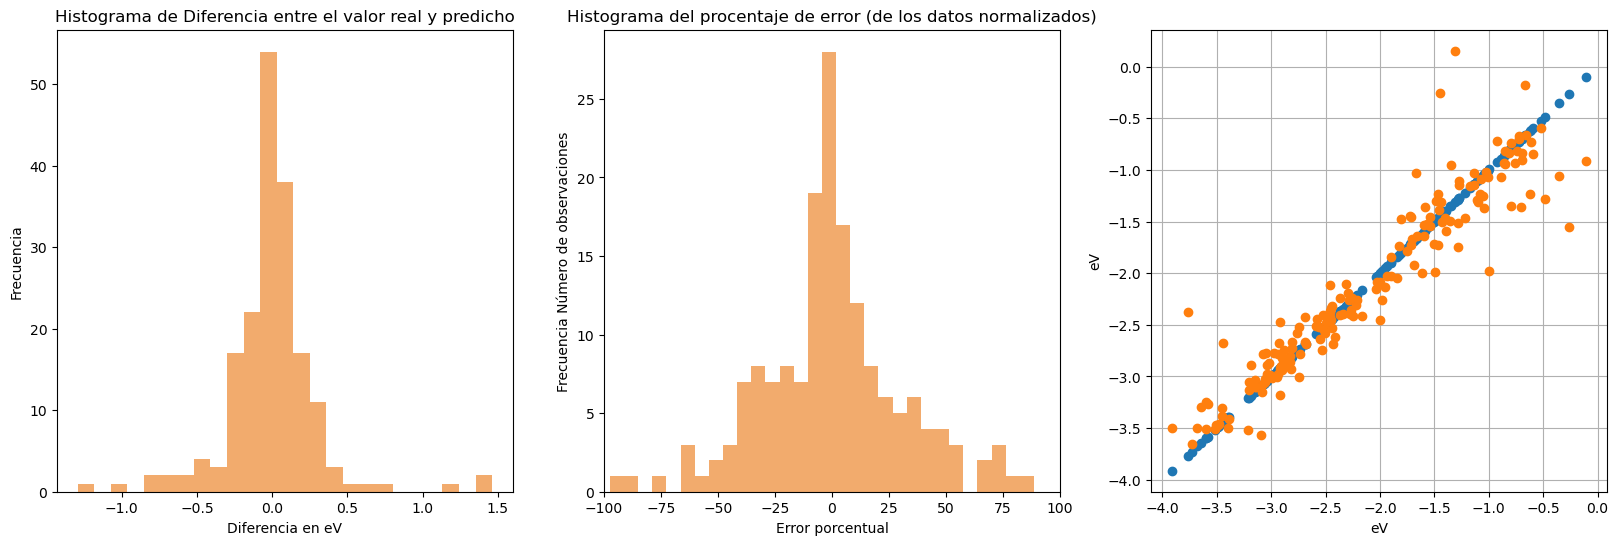

In [58]:
metrica(model12, X_train12, y_train12, X_test12, y_test12, y_mean12, y_std12, DataNorm = True)

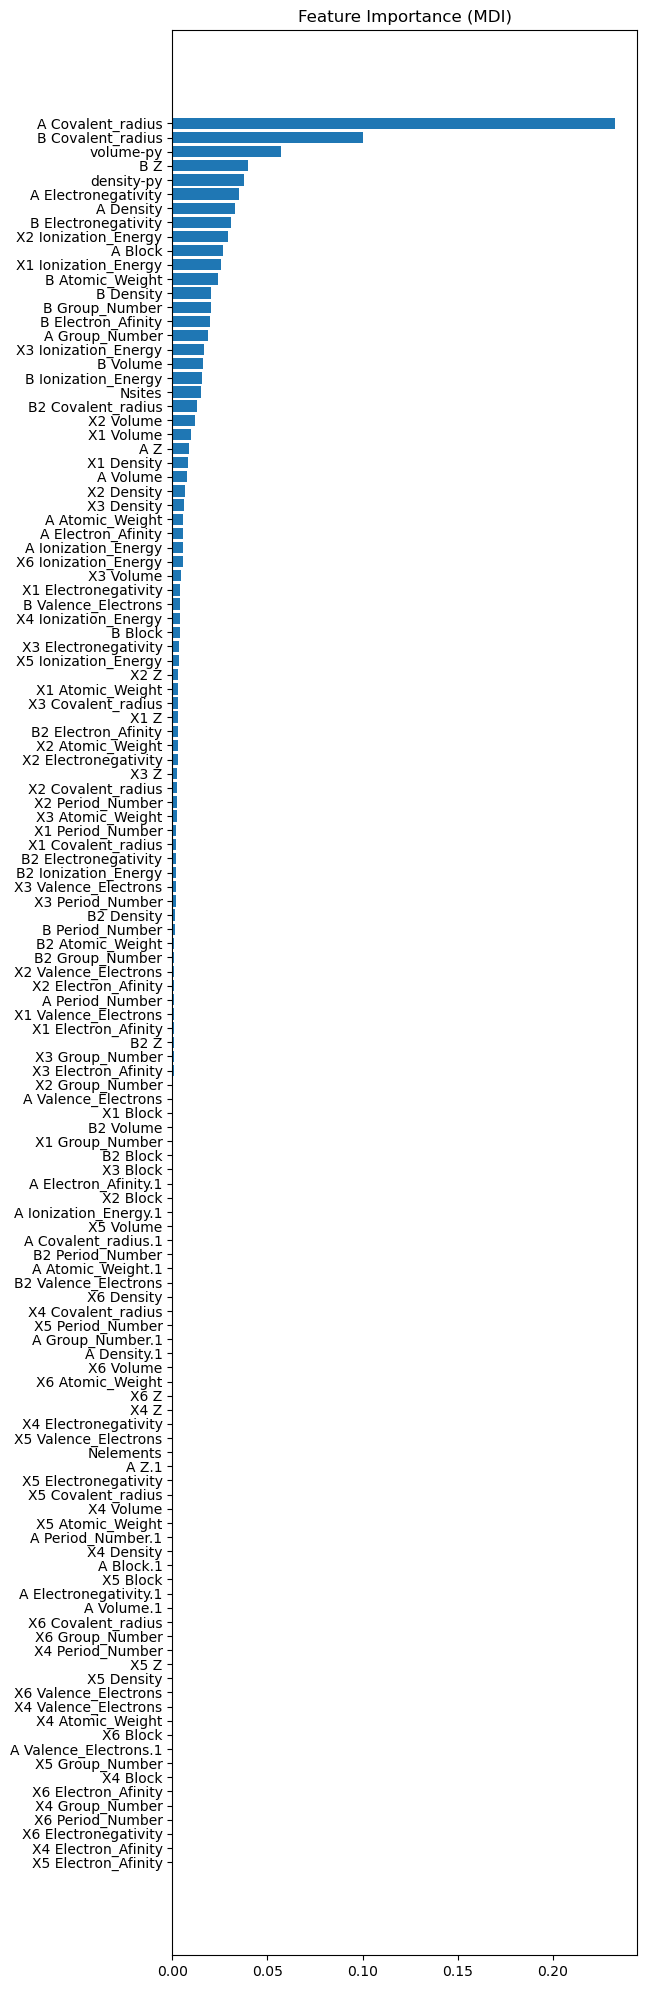

In [59]:
FeatureIm(model12, X_train12)